In [50]:
%pylab inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function

import os
import copy
import argparse
import fnmatch
import numpy as np

import scipy
from scipy.interpolate import interp1d

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
# AstroML
from astroML.plotting import hist
# Astropy.Table
from astropy.table import Table, Column, MaskedColumn, TableColumns

# Matplotlib related
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5
pylab.rcParams['legend.numpoints'] = 1

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

# Shapely related imports
from shapely.geometry import Polygon, LineString, Point
from shapely          import wkb
from shapely.ops      import cascaded_union

from descartes        import PolygonPatch


Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`%matplotlib` prevents importing * from pylab and numpy


# Test 

In [2]:
wideFrame = '/Users/songhuang/Desktop/gama_compare/database_dr15a/hsc_dr15a_wide_frame.fits'
table = fits.open(wideFrame)[1].data
print(len(table), " frames")
table.columns

69746  frames


ColDefs(
    name = 'frame_id'; format = '12A'
    name = 'frame_num'; format = 'J'
    name = 'exp_id'; format = '12A'
    name = 'exp_num'; format = 'J'
    name = 'ccd_id'; format = 'I'
    name = 'rerun'; format = '29A'
    name = 'visit'; format = 'J'
    name = 'ccd'; format = 'I'
    name = 'ccdname'; format = 'I'
    name = 'pointing'; format = 'I'
    name = 'ccdtemp'; format = 'E'
    name = 'object'; format = '9A'
    name = 'naxis1'; format = 'I'
    name = 'naxis2'; format = 'I'
    name = 'bin_fct1'; format = 'I'
    name = 'bin_fct2'; format = 'I'
    name = 'ra'; format = '12A'; unit = 'hms'
    name = 'decl'; format = '12A'; unit = 'dms'
    name = 'equinox'; format = 'E'
    name = 'ra2000'; format = 'D'
    name = 'decl2000'; format = 'D'
    name = 'radecsys'; format = '3A'
    name = 'ctype1'; format = '12A'
    name = 'ctype2'; format = '12A'
    name = 'cunit1'; format = '3A'
    name = 'cunit2'; format = '3A'
    name = 'crpix1'; format = 'E'
    name = 'crpix2'

In [22]:
a = Point(335.82, 0.096).buffer(2.5)

# Given (RA, DEC, RADIUS), returns all the overlapped (Visit, CCD) in Certain Filter

In [3]:
def genCircle(ra, dec, rad): 
    """
    Generate a circular Shape using input (RA, DEC) as center 
    and input searching radius as radius
    """
    
    try: 
        cir = Point(ra, dec).buffer(rad)
    except NameError:
        from shapely.geometry import Point
        cir = Point(ra, dec).buffer(rad)
    
    return cir 


def ccdToPolygon(frame):
    """
    Convert one (VISIT, CCD) item in the HSC frame catalog
    into a Polygon shape 
    """
    
    ccdPoly = Polygon([(frame['llcra'], frame['llcdecl']), 
                       (frame['lrcra'], frame['lrcdecl']), 
                       (frame['urcra'], frame['urcdecl']),
                       (frame['ulcra'], frame['ulcdecl'])])
    
    return ccdPoly

In [57]:
def showFrameMatch(match, ra, dec, rad, dpi=80, 
                   outPNG='frame_radec_match.png', 
                   extra=''):
    """
    """
    
    minRa  = np.nanmin(match['ra2000']) - 0.12
    maxRa  = np.nanmax(match['ra2000']) + 0.12
    minDec = np.nanmin(match['decl2000']) - 0.08
    maxDec = np.nanmax(match['decl2000']) + 0.08
    
    xSize = 12.0 
    ySize = xSize * ((maxDec - minDec) / (maxRa - minRa))
    
    fig = plt.figure(figsize=(xSize, ySize), dpi=dpi)
    ax = fig.add_subplot(111)
    
    # Turn off scientifc notation
    #ax.ticklabel_format(axis='both', style='plain')
    #ax.get_xaxis().get_major_formatter().set_scientific(False)
    #ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%6.2f'))
    
    ax.set_xlim(minRa,  maxRa)
    ax.set_ylim(minDec, maxDec)
    
    ax.text(0.09, 0.94, ("%7.3f" % ra).strip() + '  ' + ("%7.3f" % dec).strip() + \
            '  ' + extra, 
            fontsize=20, transform = ax.transAxes)
        
    for frame in match: 
        ccdPoly = ccdToPolygon(frame)
        ccdShow = PolygonPatch(ccdPoly, fc='r', ec='None',
                               alpha=0.1, zorder=1)
        ax.add_patch(ccdShow)
        ccdEdge = PolygonPatch(ccdPoly, fc='None', ec='k',
                               alpha=0.8, zorder=1)
        ax.add_patch(ccdEdge)
        
    regSearch = plt.Circle((ra, dec), rad, color='b', 
                          fill=False, linewidth=3.5, linestyle='dashed', 
                          alpha=0.8)
    ax.add_artist(regSearch)
    ax.scatter(ra, dec, marker='+', s=300, c='k', linewidth=3.0)

    ax.set_xlabel(r'RA (deg)',  fontsize=25)
    ax.set_ylabel(r'DEC (deg)', fontsize=25)

    fontsize = 16
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)

    ax.minorticks_on()
    plt.tick_params(which='major', width=2.0, length=8.0, labelsize=20)
    plt.tick_params(which='minor', width=1.8, length=6.0)

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.5)

    ax.grid(alpha=0.6, color='k', linewidth=1.5)

    fig.subplots_adjust(bottom=0.1, left=0.1,
                        top=0.98, right=0.98)

    #fig.savefig(outPNG, dpi=dpi)
    #plt.close(fig)

In [58]:
def frameRaDecSearch(catFrame, ra, dec, rad, filter='HSC-I', 
                     shortExp=False, verbose=True, fitsFile=True,
                     show=True, prefix=None, point=False): 
    """
    Find all HSC single frame CCD data that overlap with certain region 
    
    Input: 
        catFrame:   FITS catalog of frame information 
        ra, dec:    The (RA, DEC) of the field center (deg)
        rad:        Radius of the circular searching region (deg)
        
    Option: 
        filter    = 'HSC-I'   : HSC filter 
        shortExp  = False     : Whether including frame with expTime < 100s or not
    """
    
    if fitsFile:
        # Read in the Frame catalog 
        if os.path.isfile(catFrame): 
            frameTab = fits.open(catFrame)[1].data
        else: 
            raise Exception('# Can not find the input FRAME catalog : %s' % catFrame)
        
        # Filter the catalog 
        if shortExp: 
            frameUse = frameTab[frameTab['filter01'] == filter.strip()]
        else: 
            frameUse = frameTab[(frameTab['filter01'] == filter.strip()) & 
                                (frameTab['exptime'] > 35.0)]
    else: 
        frameUse = catFrame
        
    # Only use the frames that are near the search region 
    frameNear = frameUse[(np.abs(frameUse['ra2000'] - ra)    <= (rad + 0.3)) &
                         (np.abs(frameUse['decl2000'] - dec) <= (rad + 0.3))]
    if verbose:
        print("# %i frames are found in filter: %s" % (len(frameNear), filter))
    
    # Region to search 
    if point:
        cir = Point(ra, dec)
    else:
        cir = genCircle(ra, dec, rad)
    
    match = []
    for frame in frameNear: 
        ccdPoly = ccdToPolygon(frame)
        match.append(cir.intersects(ccdPoly))
        
    frameMatch = frameNear[np.asarray(match)]
    
    if verbose:
        print("# %i matched frames have been found! " % len(frameMatch))
        
    if show: 
        if prefix is None: 
            prefix = 'frame_' + ("%7.3f" % ra).strip() + '_' + ("%7.3f" % dec).strip()
        pngName = prefix + '_' + ("%3.1f" % rad).strip() + '_' + filter.strip() + '.png'
    
        showFrameMatch(frameMatch, ra, dec, rad, outPNG=pngName, 
                       extra=filter.strip())
        
    return frameMatch

# 239 frames are found in filter: HSC-I
# 37 matched frames have been found! 


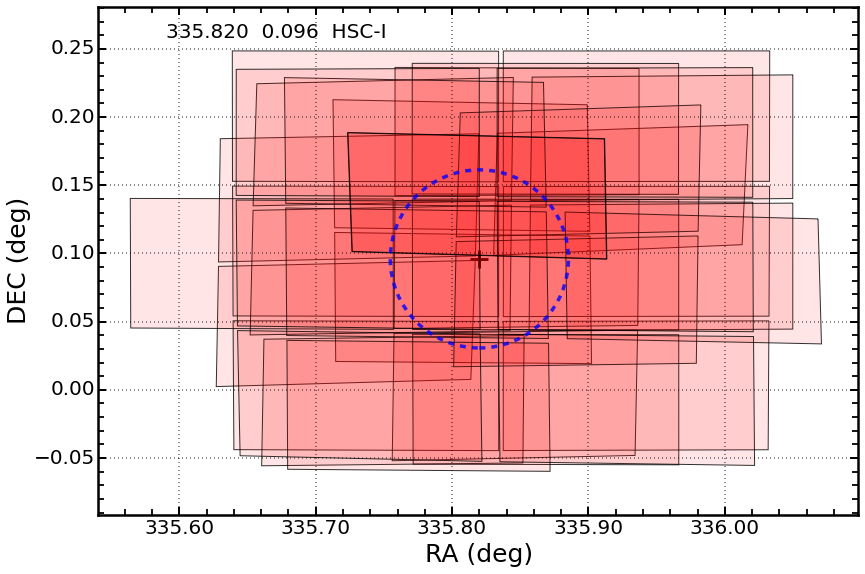

In [59]:
match = frameRaDecSearch(wideFrame, 335.82, 0.096, 0.0653)

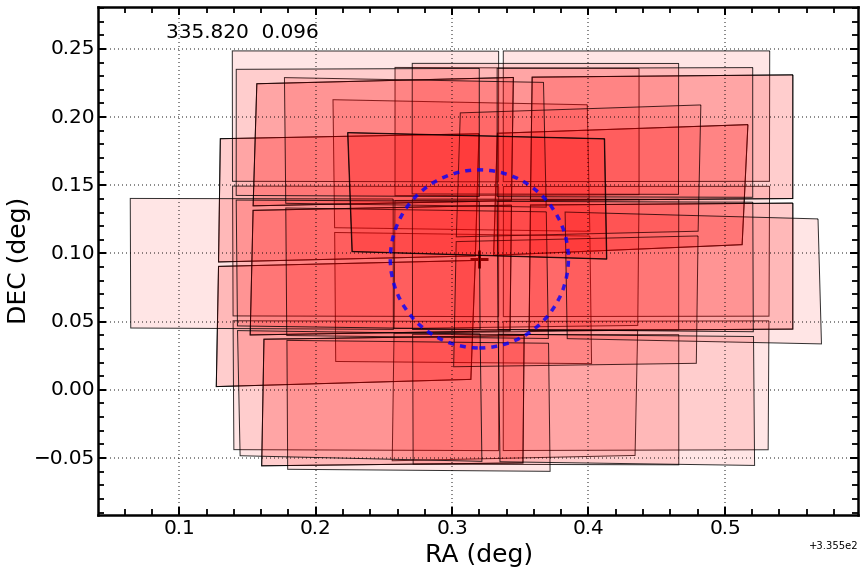

In [9]:
showFrameMatch(match, 335.82, 0.096, 0.0653)

In [25]:
for visit in np.unique(match['visit']):
    ccds = table[(table['visit'] == visit) & 
                 (table['filter01'] == 'HSC-I')]
    print(np.std(ccds['skylevel']))

165.449
226.825
212.675
212.04
122.417
117.547
112.018
113.855
113.069
119.385
122.603
